# Analyse de la performance des joueurs de la NBA

## Auteur:  Paul COFFI

L'objectif de ce projet est d'analyser les performances des joueurs de la NBA pour ce faire, une AFC pour données mixtes sera utilisée.

In [208]:
import pandas as pd 
import numpy as np 
from sklearn.decomposition import PCA
import prince
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

### 1. Analyse exploratoire

In [217]:
data= pd.read_csv('/home/paul/nba_stats/nbastats/20232024.csv')

In [233]:
data.head(10)

,RANK,NAME,TEAM,POS,AGE,GP,MPG,USG%,TO%,FTA,...,APG,SPG,BPG,TPG,P+R,P+A,P+R+A,VI,ORtg,DRtg
0,1,Joel Embiid,Phi,C,30.2,6,41.4,35.7,15.8,78,...,5.7,1.2,1.5,4.2,43.8,38.7,49.5,12.2,117.1,108.0
1,2,Jalen Brunson,Nyk,G,27.8,13,39.8,36.4,9.3,120,...,7.5,0.8,0.2,2.7,35.7,39.8,43.2,9.3,114.8,114.7
2,3,Damian Lillard,Mil,G,33.9,4,39.1,31.4,10.0,38,...,5.0,1.0,0.0,2.3,34.5,36.3,39.5,8.2,127.6,115.7
3,4,Shai Gilgeous-Alexander,Okc,G,25.9,10,39.9,32.3,8.9,81,...,6.4,1.3,1.7,2.2,37.4,36.6,43.8,11.2,118.3,106.9
4,5,Tyrese Maxey,Phi,G,23.6,6,44.6,28.1,8.6,28,...,6.8,0.8,0.3,2.2,35.0,36.7,41.8,9.1,120.9,113.3
5,6,Donovan Mitchell,Cle,G,27.8,10,38.2,34.3,11.1,65,...,4.7,1.3,0.3,2.8,35.0,34.3,39.7,9.5,111.5,108.3
6,7,Luka Doncic,Dal,G,25.3,20,41.2,32.9,15.3,141,...,8.4,1.8,0.4,4.1,38.5,37.3,46.9,12.9,110.5,108.9
7,8,Nikola Jokic,Den,C,29.3,12,40.2,30.0,14.1,71,...,8.7,1.4,0.7,3.3,42.1,37.3,50.8,14.9,125.6,106.4
8,9,LeBron James,Lal,F,39.5,5,40.8,29.0,16.1,23,...,8.8,2.4,1.0,3.8,34.6,36.6,43.4,11.6,118.5,110.4
9,10,Anthony Davis,Lal,C,31.3,5,41.6,25.7,10.5,26,...,4.0,0.4,1.6,2.2,43.4,31.8,47.4,11.6,127.4,105.1


In [235]:
id= data['NAME']
data= data.drop(columns= ['NAME', 'TEAM','RANK'])

Nous disposons des id des joueurs comme le nom, l'équipe et le poste et de informances sur les performances des joueurs comme le nombre de points par match, le nombre de passes décisives par match, le nombre de tirs à points et à mid-distance...

In [237]:
group_by_pos_ppg= data.groupby(by= 'POS')[['PPG']].mean()
group_by_pos_apg= data.groupby(by= 'POS')[['APG']].mean()
group_by_pos_rpg= data.groupby(by= 'POS')[['RPG']].mean()

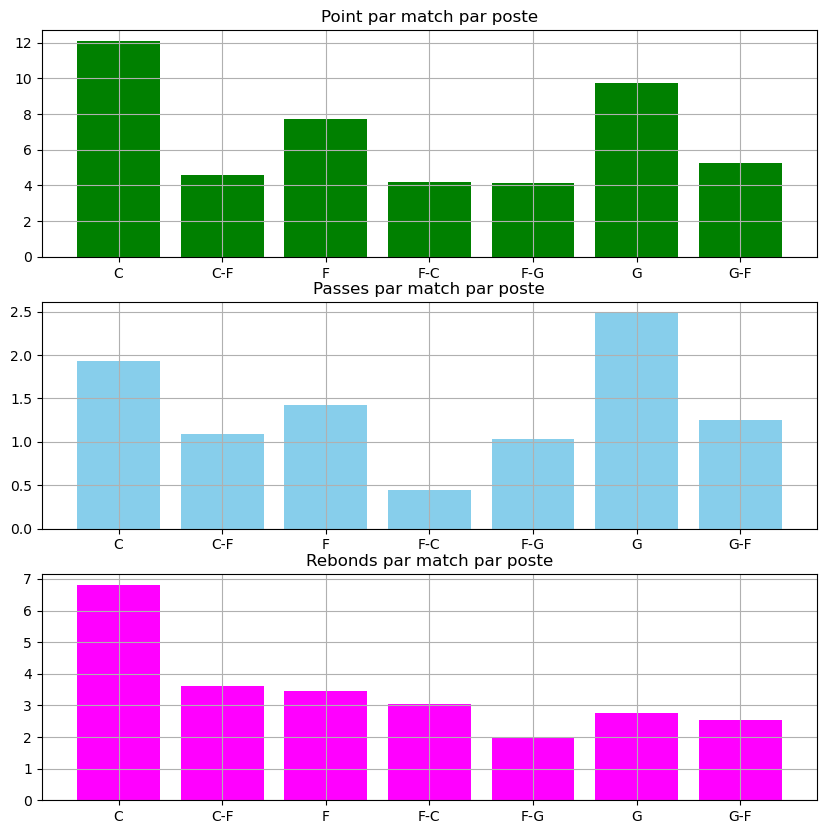

In [239]:
fig, axs= plt.subplots(3,1, figsize=(10,10))

axs[0].bar(x= group_by_pos_ppg.index.values, height= group_by_pos_ppg['PPG'].values, color= 'green')
axs[0].set_title('Point par match par poste')
axs[0].grid()

axs[1].bar(group_by_pos_apg.index.values, group_by_pos_apg['APG'].values, color= 'skyblue')
axs[1].set_title('Passes par match par poste')
axs[1].grid()

axs[2].bar(group_by_pos_rpg.index.values, group_by_pos_rpg['RPG'].values, color= 'magenta')
axs[2].set_title('Rebonds par match par poste')
axs[2].grid()

plt.show()

**Analyse des indicateurs principaux (PPG,APG et RPG)**

- Les pivots et les meneurs inscrivent le plus de points et de passes décisives par match
- les pivots inscrivent le nombre de rebonds par match et le nombre de rebonds par match est une fonction décroissante de la taille.

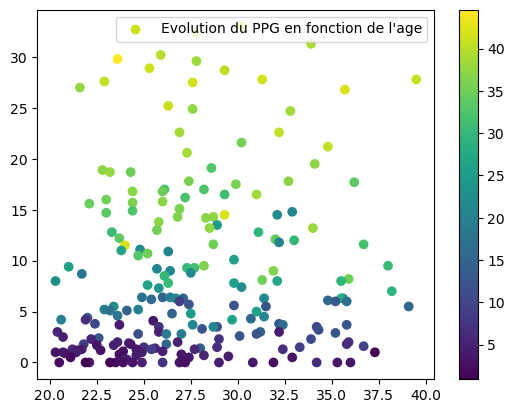

In [202]:
plt.figure()
plt.scatter(data['AGE'], data['PPG'], c= data['MPG'], label="Evolution du PPG en fonction de l'age")
plt.colorbar()
plt.legend()
plt.show()

la structure indique que le nombre de points par match dépend du nombre de minutes et de l'age.
La tranche d'age 25-33 est celle qui concentre le plus de PPG élévés.

Pour analyser les statistiques avancées, nous allons effectuer dans un premier temps une réduction de la dimension suivie d'un clustering à l'aide du K-means.

### 2. Réduction de la dimension

In [586]:
famd= prince.FAMD(n_components= 2, random_state= 5)
famd.fit(data)
data_reduced= famd.row_coordinates(data)

In [588]:
print(data_reduced)

component          0         1
0          11.363937 -1.729148
1          14.163876  2.928159
2           6.448795 -2.013238
3          12.506178  0.009656
4           7.438260 -2.573096
..               ...       ...
208        -7.490276  0.923905
209        -6.010974  0.420189
210        -7.572209  0.945603
211        -7.437570  1.492522
212        -6.699471  1.044191

[213 rows x 2 columns]


### 3. Clustering à partir de la réduction en utilisant le KMeans

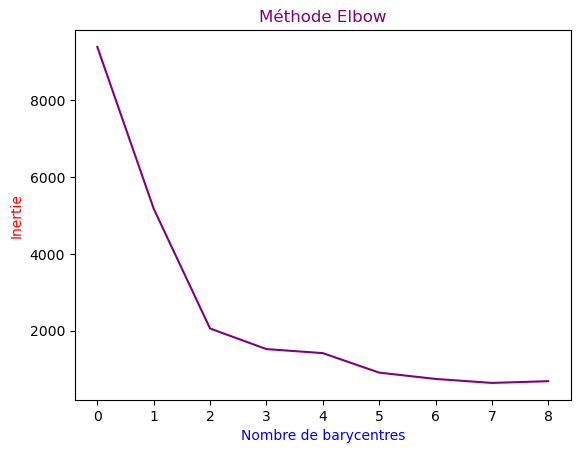

In [590]:
inertia= []
for k in range(1,10):
    cluster= KMeans(n_clusters= k)
    cluster.fit(data_reduced)
    inertia.append(cluster.inertia_)
plt.figure()
plt.plot(inertia, color= 'purple')
plt.xlabel('Nombre de barycentres', color= 'blue')
plt.ylabel('Inertie', color= 'red')
plt.title('Méthode Elbow', color= 'purple')
plt.show()

Ce graphique suggère d'utiliser 3 groupes.

In [592]:
cluster= KMeans(n_clusters= 3)
data_reduced['class']= cluster.fit_predict(data_reduced)
data_reduced['name']= id

In [594]:
print(data_reduced)

component          0         1  class                     name
0          11.363937 -1.729148      2              Joel Embiid
1          14.163876  2.928159      2            Jalen Brunson
2           6.448795 -2.013238      2           Damian Lillard
3          12.506178  0.009656      2  Shai Gilgeous-Alexander
4           7.438260 -2.573096      2             Tyrese Maxey
..               ...       ...    ...                      ...
208        -7.490276  0.923905      0              David Roddy
209        -6.010974  0.420189      0           Gordon Hayward
210        -7.572209  0.945603      0           Thaddeus Young
211        -7.437570  1.492522      0              T.J. Warren
212        -6.699471  1.044191      0            Isaiah Thomas

[213 rows x 4 columns]


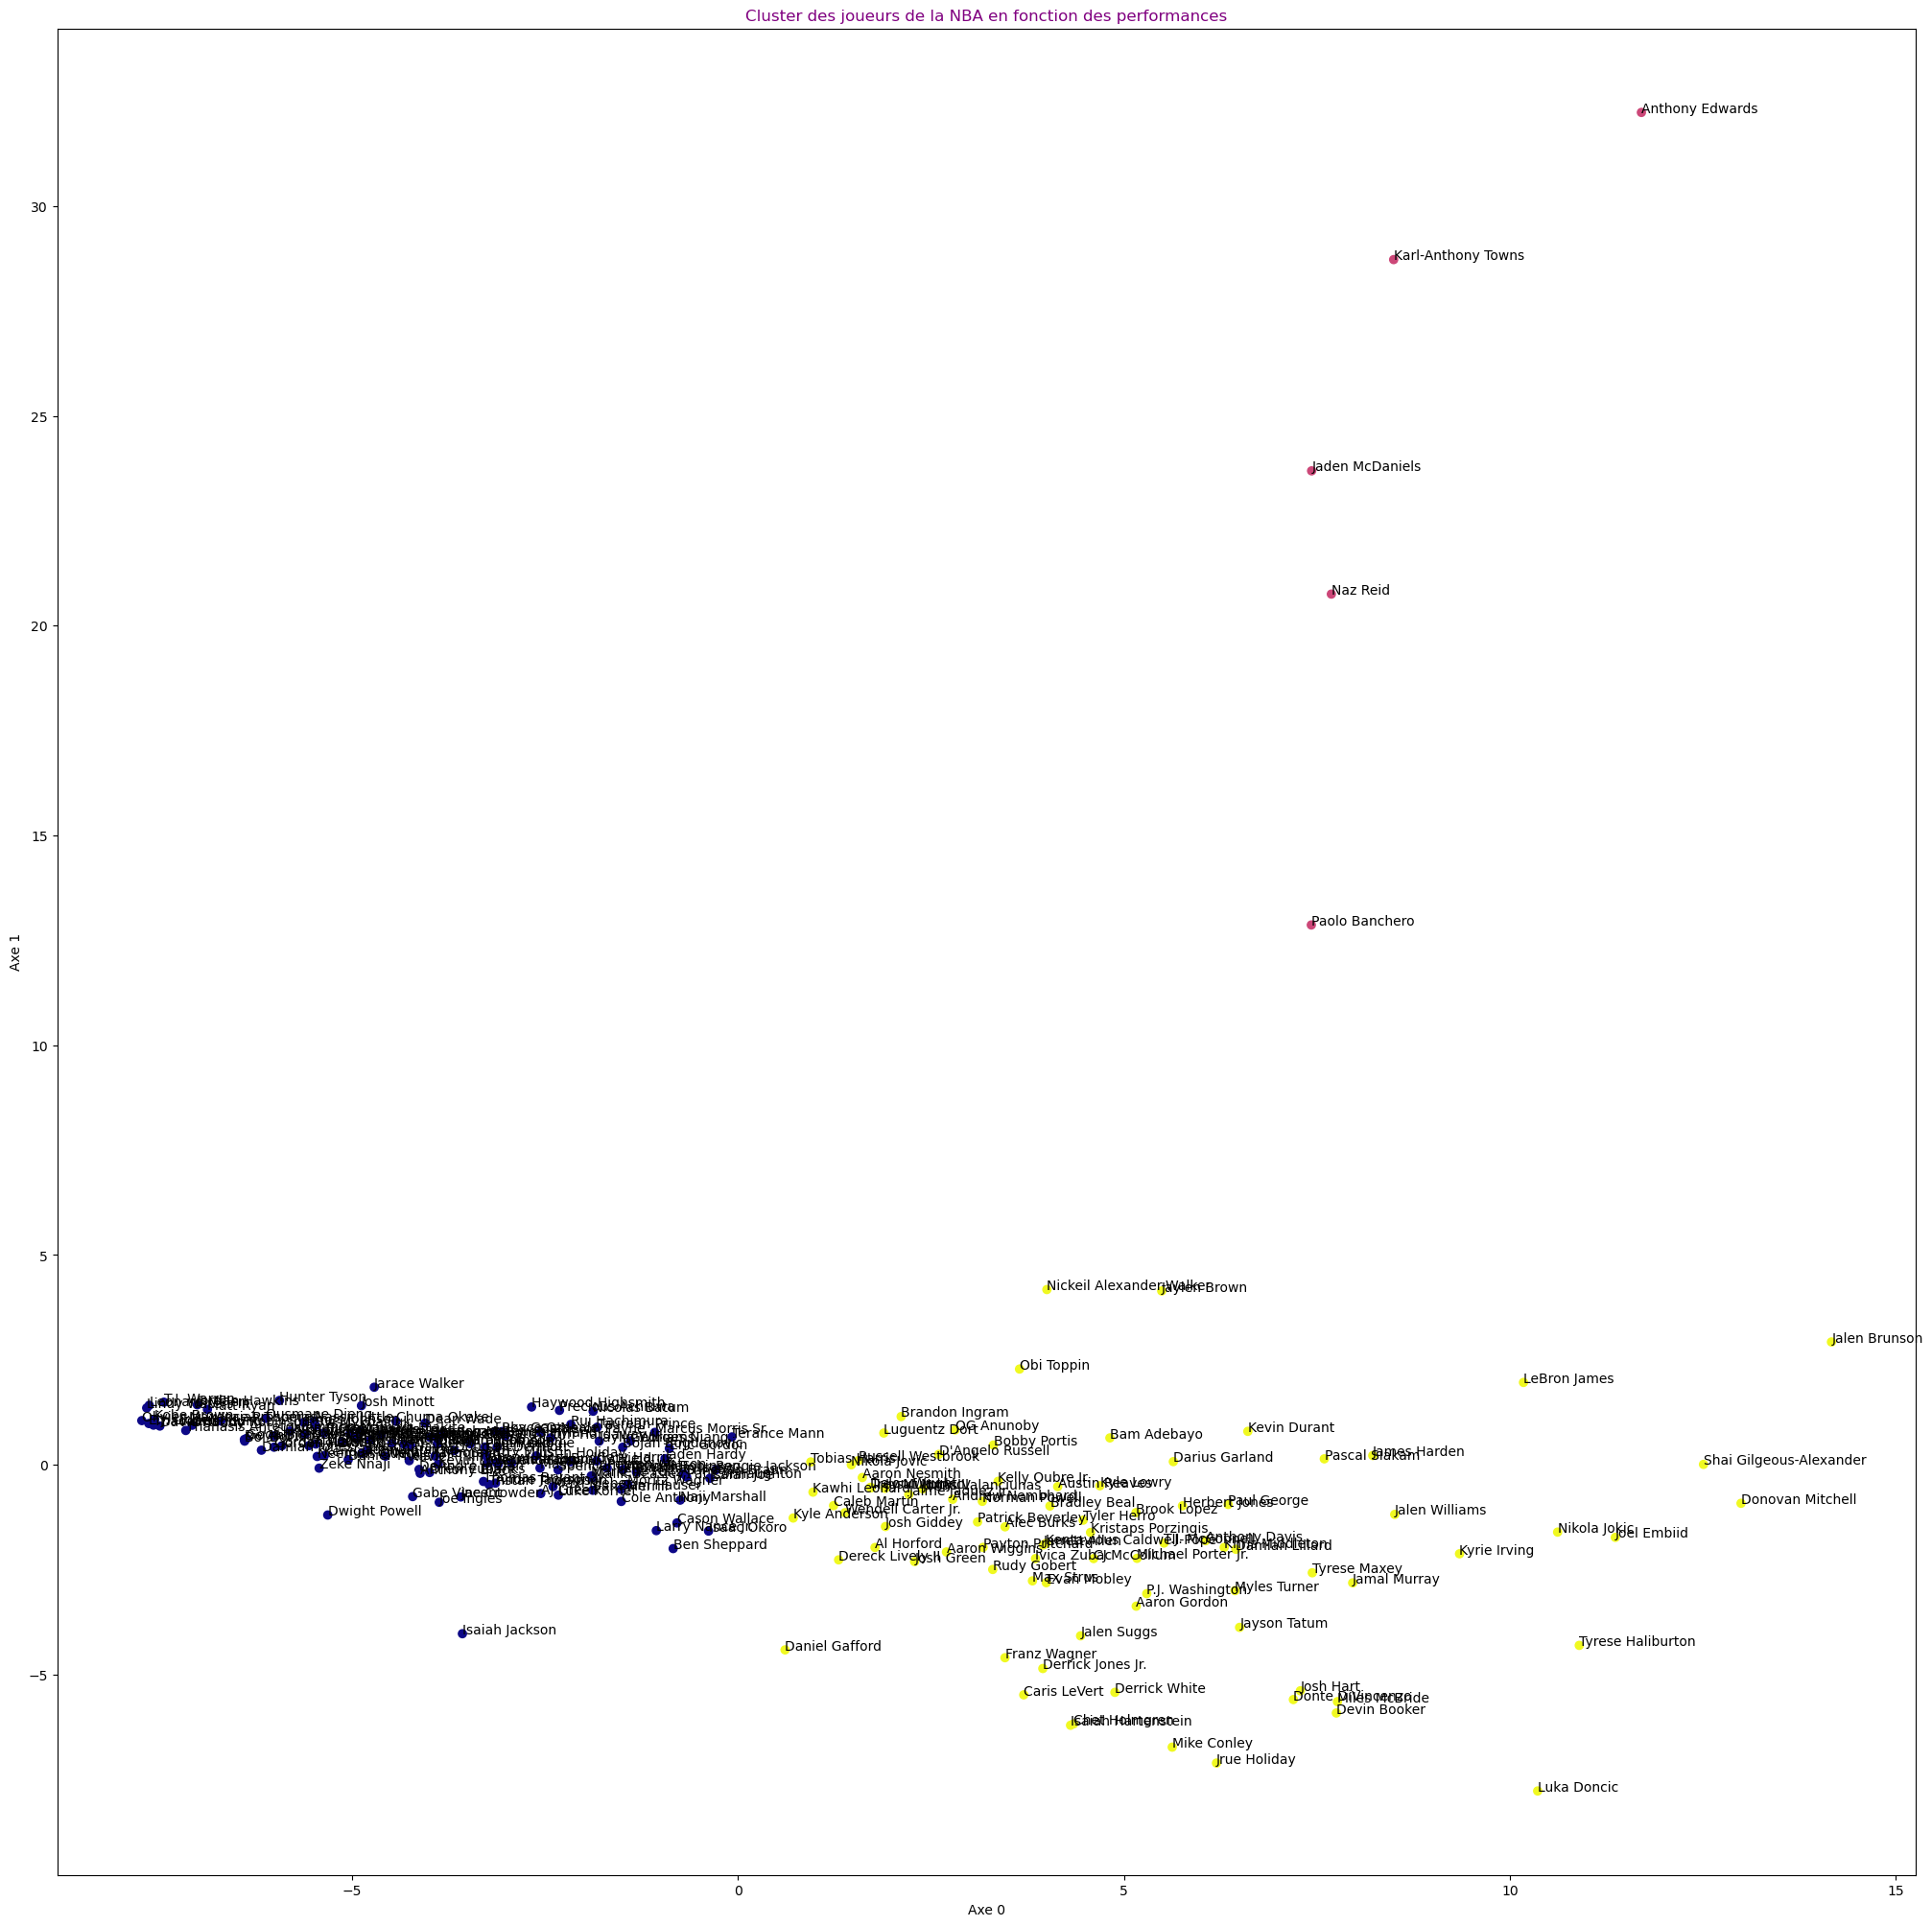

In [596]:
plt.figure(figsize=(25,25))
plt.scatter(data_reduced[0], data_reduced[1], c= data_reduced['class'], cmap= 'plasma')
plt.title('Cluster des joueurs de la NBA en fonction des performances', color= 'purple')
plt.xlabel('Axe 0')
plt.ylabel('Axe 1')

for i, label in enumerate(data_reduced['name']):
    plt.annotate(label, (data_reduced.iloc[i,0], data_reduced.iloc[i,1]), fontsize= 10 )

    


## Conclusion

D'après cette étude, on peut identifier 3 types de joueurs en fonctions des performances.
On peut identifier quelques joueurs qui ont des performances significativement différentes par rapport au reste des deux groupes: Luka Doncic, Paulo Banchero, Jalen brunson, Karl Anthony Towns, jaden McDaniels, Naz Reid et Anthony Edwards; les 4 derniers jouent dans la meme équipe.